<a href="https://colab.research.google.com/github/aastha073/CS-525/blob/main/Assignments/cs558_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # dripyto# install basical image libs
!pip install Pillow>=5.0.0
!pip install -U image
!pip install wheel

# install torch and torchvision (a utility library for computer vision that provides many public datasets and pre-trained models)
!pip install torch torchvision

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 86.2 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=0340631639f48a5b7323c7dfb6c6eb59163e775f9237bffb3907996fbbeb8e68
  Stored in directory: /root/.cache/pip/wheels/58/30/d8/3212cd83eeeeee0a1f0c7b9b7bd0674a2b9f09342870473a2a
Successfully built image


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
import matplotlib.pyplot as plt

In [3]:
cuda0 = torch.device("cuda:0") # pick the GPU at index 0
torch.set_printoptions(sci_mode=False) # Prevent the confusion matrices from coming

In [4]:
# Utility functions
def input2image(tensor):
    denormed = (tensor.detach() * 127.5 + 128).clamp_(0, 255)
    c, h, w = tensor.shape

    r = denormed[0]
    g = denormed[1]
    b = denormed[2]

    img = torch.zeros((h, w, c))
    img[:,:,0] = r
    img[:,:,1] = g
    img[:,:,2] = b

    return PIL.Image.fromarray(img.to("cpu", torch.uint8).numpy())

def mask2image(tensor):
    return PIL.Image.fromarray(tensor.to("cpu", torch.uint8).numpy()[0])

In [ ]:
import os
import torch
from torchvision.datasets import SBDataset
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision import tv_tensors

# Load SBD dataset
# https://docs.pytorch.org/vision/main/generated/torchvision.datasets.SBDataset.html
transform_pipeline = v2.Compose([
    v2.RandomResizedCrop(size=(256, 256), scale=(0.75, 1.0)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

def explicit_transform(image, target):
    image = tv_tensors.Image(image)
    target = tv_tensors.Mask(target)
    out_image, out_target = transform_pipeline(image, target)
    return out_image, out_target.long()

# If you encounter an issue during download and need to attempt to fetch the data again, delete this directory.
data_path = "data/SBD"
download = not os.path.exists(data_path)
train_set = SBDataset(
    root=data_path,
    image_set="train",
    mode="segmentation",
    transforms=explicit_transform,
    download=download
)

val_set = SBDataset(
    root=data_path,
    image_set="val",
    mode="segmentation",
    transforms=explicit_transform
)

# If you run out of memory, reduce the batch size.
# To speed up training, use a larger batch size.
# If desired, not shuffling the validation set allows testing on a fixed subset.
batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

Training samples: 8498
Validation samples: 2857
Input shape:  torch.Size([3, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Unique labels:  tensor([0, 8, 9])
torch.Size([1, 256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

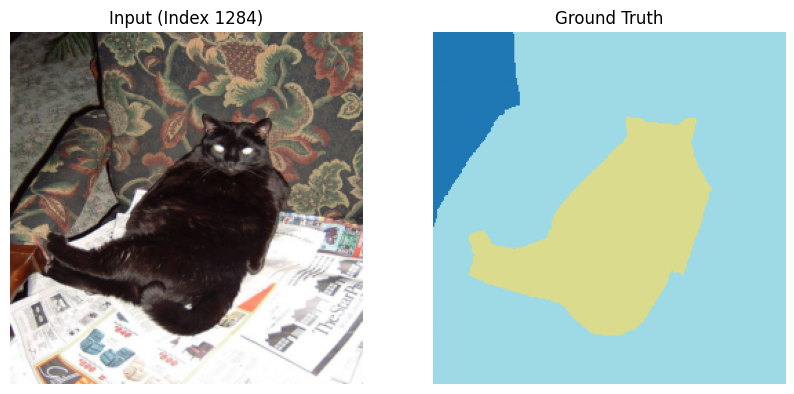

In [ ]:
# Simple tests and visualizations
print(f"Training samples: {len(train_set)}")
print(f"Validation samples: {len(val_set)}")

idx = 1284
img, mask = train_set[idx]

print("Input shape: ", img.shape)
print("Mask shape: ", mask.shape)

print("Unique labels: ", torch.unique(mask))

print(mask.shape)

plt.figure(figsize=(10, 5))

# Input Image
plt.subplot(1, 2, 1)
plt.imshow(input2image(img))
plt.title(f"Input (Index {idx})")
plt.axis("off")

# Ground Truth
plt.subplot(1, 2, 2)
plt.imshow(mask2image(mask), cmap="tab20")
plt.title("Ground Truth")
plt.axis("off")

In [ ]:
# Define a simple model
# This will NOT be sufficient, but can get you started
# You should at least two more layers to receive partial credit

class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 21, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        return x

In [ ]:
# TODO: network specification goes here

class BasicUNet(nn.Module):
    def __init__(self, in_channels, c, out_channels):
        super(BasicUNet, self).__init__()

    def forward(self, img):
        return out

In [ ]:
net = BasicUNet(in_channels=3, c=64, out_channels=2).to(cuda0)

3 64 2


In [ ]:
# This network outputs 2 logits per pixel, as verified below
# using a random input tensor.
# IT IS VERY IMPORTANT THAT YOUR NETWORK PASSES THIS TEST
# There should be 3 input channels (RGB).
# TODO: These image dimensions will work, but try different ones as well
random_input = torch.randn(4, 3, 200, 160, device=cuda0)
output = net(random_input)

# The dimensions of the input are [B, C, H, W]
# where B is the number of batches, C is the number of channels,
# H is the height of input, and W is the height of the input.
# The output shape should match the input shape in every dimension,
# except C.  The number of output channels MUST BE 2.
print(random_input.shape)
print(output.shape)

torch.Size([4, 3, 200, 160])
torch.Size([4, 2, 200, 160])


In [ ]:
def train(net, optim, crit):
    net.train()

    for i, (image_cpu, labels_cpu) in enumerate(train_loader):
        # TODO: convert labels to 0 and 1

        # put data onto GPU
        image = image_cpu.to(cuda0) # Shape: [B, 3, H, W]
        labels = labels_cpu.to(cuda0) # Shape: [B, 1, H, W]

        # clear gradient
        optim.zero_grad()

        # forward through the network
        output = net(image)

        labels = labels.squeeze(1) # [B, 1, H, W] -> [B, H, W]

        loss = crit(output, labels.long())

        # compute loss and gradient
        loss.backward()
        optim.step()

        # if i % 100 == 0:
        #     print(f"Loss: {loss.item():.4f}")

In [ ]:
import torch
import numpy as np

def evaluate(net):
    total = 0
    correct = 0

    net.eval() # puts the network in eval mode. this is important when the
               # network has layers that behave differently in training and
               # evaluation time, e.g., dropout and batch norm.

    confusion_matrix = np.zeros((2, 2))

    # gradients are not tracked in this context manager
    # since we are evaluating, gradients are not needed
    # and we can save some time and GPU memory.
    with torch.no_grad():
        for i, (image_cpu, labels_cpu) in enumerate(val_loader):
            # TODO: convert labels to 0 and 1

            # 2. Move to GPU
            image = image_cpu.to(cuda0)
            labels = labels_cpu.to(cuda0) # Shape: [8, 1, 256, 256]

            labels = labels.squeeze(1) # Now [8, 256, 256]

            output = net(image) # Shape: [8, 2, 256, 256]

            prediction = torch.argmax(output, dim=1) # Shape: [8, 256, 256]

            total += prediction.shape[0] * prediction.shape[1] * prediction.shape[2]
            correct += (prediction == labels).sum().item()  # `.item()` retreives a python number from a 1-element tensor

            # TODO: Populate the confusion matrix.

            # early abort for development
            # if i > 10:
            #     break

    net.train() # Switch back to train mode

    # Your confusion matrix should be a 2x2 Numpy array.
    # correct / total should be a decimal value between 0 and 1
    return confusion_matrix, correct / total

In [ ]:
# main
# TODO: adjust number of epochs
num_epochs = 2

lr = 0.0005

class_weights = torch.tensor([1.0, 2.5])
# About 70% of the pixels are background, so the network can do pretty well
# just by guessing that all pixels are backround pixels.  To get around this,
# assign a proportionately higher weight to foreground pixels.

criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(cuda0)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    _, accuarcy = evaluate(net)
    print(f"Epoch {epoch}\tValidation Accuracy {accuarcy*100:.4f}%")
    train(net, optimizer, criterion)

confusion_matrix, accuracy = evaluate(net)
print(f"Done!\tValidation Accuracy: {accuarcy*100:.4f}%")
print("Confusion Matrix:\n", confusion_matrix)

Epoch 0	Validation Accuracy 67.8156%
Done!	Validation Accuracy: 67.8156%
Confusion Matrix:
 [[83457708. 10922473.]
 [41210865. 51645306.]]


In [ ]:
# You should be able to achieve an IoU of slightly over 0.5

# Input: 2x2 Numpy confusion matrix
# Output: Float between 0 and 1
def compute_iou(confusion_matrix):
    # TODO: Compute intersection over union
    return 0
print(compute_iou(confusion_matrix))

0.4976486877203753


In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_results(net, dataset, idx):
    net.eval()
    img, mask = dataset[idx]
    mask[mask > 1] = 1
    img_batch = img.unsqueeze(0).to(cuda0)
    with torch.no_grad():
        output = net(img_batch) # Shape: [1, 2, 256, 256]
        pred_mask = torch.argmax(output, dim=1)

    plt.figure(figsize=(15, 5))

    # Input Image
    plt.subplot(1, 3, 1)
    plt.imshow(input2image(img))
    plt.title(f"Input (Index {idx})")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(mask2image(mask), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(mask2image(pred_mask), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
    net.train()

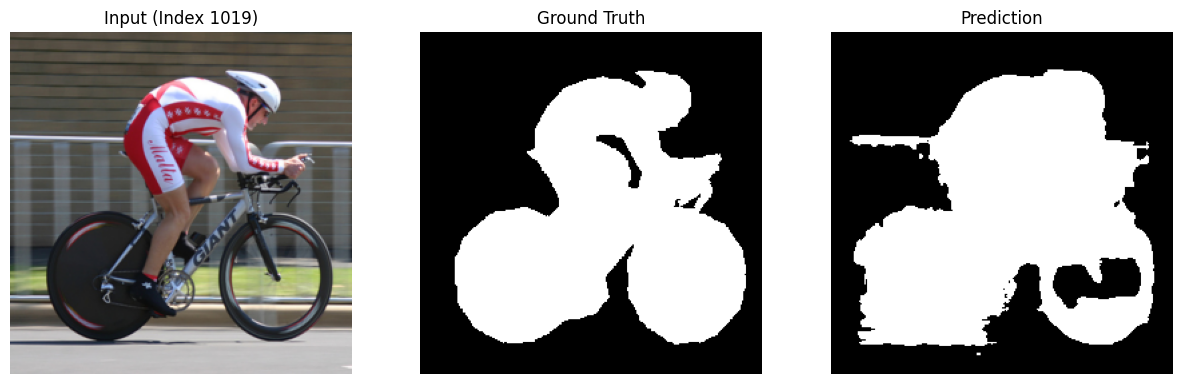

In [ ]:
visualize_results(net, val_set, 1019)